# FaceForge
### A Face Generation Project

    This project aims to generate realistic human faces using Generative Adversarial Networks (GANs) on the CelebA dataset. By combining different neural network architectures, such as ResNet, Inception Net, and U-Net, in both the generative and discriminative parts of the GAN, the model is trained to generate high-quality face images from random noise input. The CelebA dataset provides a diverse collection of celebrity images, making it an ideal choice for training the GAN model. The project showcases the effectiveness of GANs in generating lifelike faces and opens up possibilities for further advancements in the field of face synthesis and generation.

In [1]:
# Importing Datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.nn.init as init
import torch.nn.utils.spectral_norm as spectral_norm

from discriminator import Discriminator
from generator import Generator

import numpy as np
import matplotlib.pyplot as plt


from ignite.engine import Engine, Events
import ignite.distributed as idist

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# HyperParameters
batch_size = 128
noise_dim = 200
image_channels = 3
num_epochs = 50
lr = 0.0002

In [5]:
# Discriminator
discriminator = Discriminator(image_channels).to(device)
discriminator.load_state_dict(torch.load("discriminator.pth"))

<All keys matched successfully>

In [4]:
# Generator
generator = Generator(noise_dim, image_channels)
generator.load_state_dict(torch.load("generator.pth"))

<All keys matched successfully>

In [5]:
# If there are one more cuda device it would be great:) 
if torch.cuda.device_count() > 1:
    discriminator = nn.DataParallel(discriminator)
    generator = nn.DataParallel(generator)
torch.cuda.device_count()

1

In [ ]:
# Defining the Loss Function
bce = nn.BCELoss()

generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

### Reading Data

In [5]:
# Transform function
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
# Read the dataset and create a data loader
dataset = datasets.CelebA(root='dataset', split='train', download=False, transform=transform)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2, drop_last=True)

In [9]:
# Generate face function to visualize
def generate_face(path=None):
    fig, axes = plt.subplots(1, 6,  figsize=(12, 6))
    imgs = generator(torch.randn(6, noise_dim, 1, 1).to(device)).cpu().detach().numpy()
    imgs = np.transpose(imgs, (0, 2, 3, 1))

    for i in range(6):
        axes[i].imshow(imgs[i])
        axes[i].axis('off')

    if path is not None:
        plt.savefig(path)

    plt.show()
    plt.close()


### Visualizing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


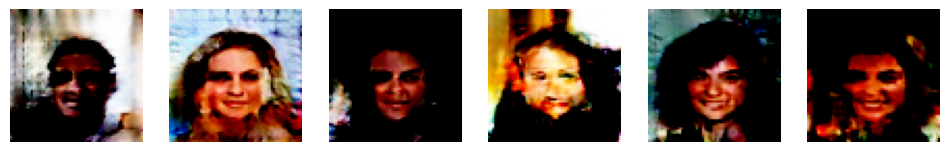

In [10]:
generate_face()

## Training

In [ ]:

for epoch in range(1, num_epochs + 1):
    generate_face(f"saved_imgs/{epoch-1}.png")
    for batch_idx, real_images in enumerate(data_loader):
        real_images = real_images[0].to(device)

        # Train the discriminator
        discriminator_optimizer.zero_grad()

        # Generate fake images using the generator
        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake_images = generator(noise)

        # Calculate discriminator scores for real and fake images
        real_scores = discriminator(real_images)
        fake_scores = discriminator(fake_images.detach())

        # Calculate the discriminator loss
        d_loss = bce(real_scores, torch.ones_like(real_scores)) + bce(fake_scores, torch.zeros_like(fake_scores))

        # Backpropagate and update discriminator weights
        d_loss.backward()
        discriminator_optimizer.step()

        # Train the generator
        generator_optimizer.zero_grad()

        # Generate new fake images using the updated generator
        noise = torch.randn(batch_size, noise_dim, 1, 1).to(device)
        fake_images = generator(noise)

        # Calculate discriminator scores for the generated images
        fake_scores = discriminator(fake_images)

        # Calculate the generator loss
        g_loss = bce(fake_scores, torch.ones_like(fake_scores)) + generator.compute_weight_decay_loss()

        # Backpropagate and update generator weights
        g_loss.backward()
        generator_optimizer.step()

        # Print the losses for monitoring the training progress
        if batch_idx % 100 == 0:
            torch.save(generator.state_dict(), "generator.pth")
            torch.save(discriminator.state_dict(), "discriminator.pth")

            print(f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(data_loader)}], "
                  f"Discriminator Loss: {d_loss.item():.8f}, Generator Loss: {g_loss.item():.4f}")


## Evaluation

In [9]:
# Function to calculate the Inception Score
def calculate_inception_score(logits):
    # Convert logits to probabilities
    preds = F.softmax(logits, dim=1)

    # Calculate the average class probabilities
    avg_probs = torch.mean(preds, dim=0)

    # Calculate the KL divergence for each image
    kl_divs = torch.sum(preds * torch.log(preds / avg_probs), dim=1)

    # Calculate the exponentiation of the average KL divergence
    inception_score = torch.exp(torch.mean(kl_divs))

    return inception_score

In [7]:
imgs = generator(torch.randn(128, noise_dim, 1, 1).to(device))

# Calculate Inception Score for the generated logits
inception_score = calculate_inception_score(imgs)
print("Inception Score:", inception_score.item())

: 

: 